# Main results for CMNIST

Script reproducing our main results from the analysis of the CMNIST data using a VAE, iVAE and NF-iVAE and the iCaRL algorithm.

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
from torchvision.transforms import ToTensor

transform_to_tensor = ToTensor()

c:\Users\verga\anaconda3\envs\02456\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataloader and the three different VAEs
import CMNISTdataloader_pytorch as cmnist
import VAE as class_vae
import iVAE as class_ivae
import NFiVAE as class_nfivae
import classifier as invariant_classifier
from ReparameterizedDiagonalGaussian import ReparameterizedDiagonalGaussian

Use the dataloader to load:

1) Training data from environment 1
2) Training data from environment 2 (& and concatenate this with 1))
3) Test data from environment 3

Below can also be seen a visualization of 1 sample with its label and environment and 64 samples without.

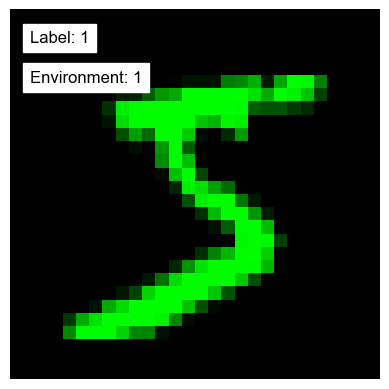

In [3]:
cmnist_data1 = cmnist.CMNISTDataset(pt_file = "../data/ColoredMNIST/train1.pt"
                            , environment = 1
                            , transform = transform_to_tensor)
cmnist_data2 = cmnist.CMNISTDataset(pt_file = "../data/ColoredMNIST/train2.pt"
                            , environment = 2
                            , transform = transform_to_tensor)
train_loader = DataLoader(ConcatDataset([cmnist_data1, cmnist_data2]), batch_size=256, num_workers=0, drop_last = True)

cmnist_test_data = cmnist.CMNISTDataset(pt_file = "../data/ColoredMNIST/test.pt"
                                 , environment = 3
                                 , transform = transform_to_tensor)
test_loader = DataLoader(cmnist_test_data, batch_size = 512, num_workers = 0, drop_last = True)

def show_CMNIST(image, label, environment):
    """Show image with landmarks"""
    plt.figure
    plt.imshow(image.permute(1,2,0))
    plt.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 12)
    plt.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 12)
    plt.axis('off')
    plt.show
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure()

for i in range(1):
    sample = cmnist_data1[i]

    #print(i, sample['image'].shape, sample['label'].shape)

    plt.tight_layout()
    plt.axis('off')
    show_CMNIST(**sample)

    if i == 3:
        plt.show()
        break

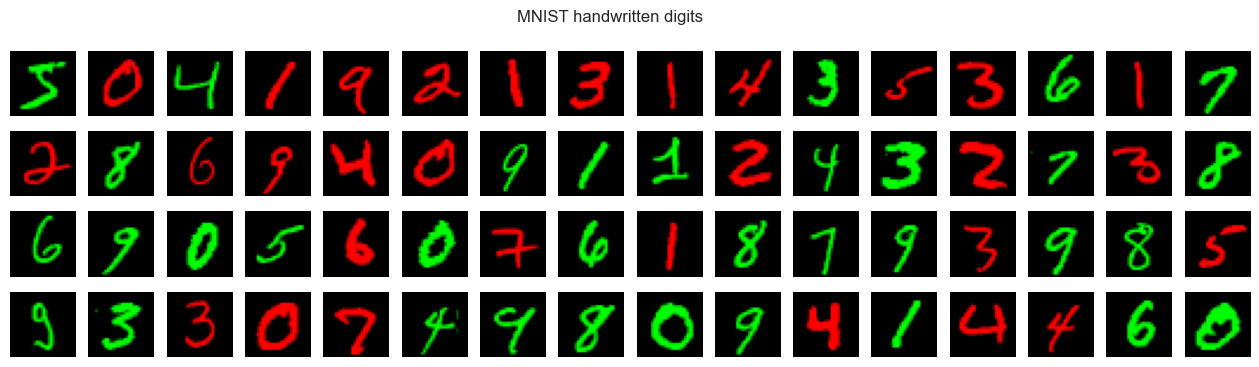

In [4]:
#plot a few CMNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample['image']
label = sample['label']
environment = sample['environment']

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].permute(1,2,0))
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

In [5]:
#Show Cmnist function for VAE training.
def show_CMNIST(image, label, environment, ax):
    """Show image with landmarks"""
    ax.figure
    ax.imshow(image.permute(1,2,0))
    ax.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.axis('off')

# Phase 1 iCaRL with VAE

# Phase 2 iCaRL: PC algorithm with VAE

# Phase 3 iCaRL: Invariant classifier with VAE

# Phase 1 iCaRL with iVAE

In [ ]:
#### Initialization
from collections import defaultdict
# define the models, evaluator and optimizer

# iVAE
beta = 1
latent_features = 10 #Hyper parameter
ivae = class_ivae.iVAE(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-4) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

#### Training loop
torch.manual_seed(1)
num_epochs = 100 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = "cpu"
# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
ivae = ivae.to(device)
sample_counter = 0
# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader: #tqdm
        sample_counter += 1
        
        x = sample['image']
        x = x.to(device)

        y = sample['label'].reshape(-1,1)
        y = y.to(device)

        e = sample['environment'].reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = ivae.VariationalInference(x, y, e, beta)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    px = outputs['px']
    samples = px.sample()
    samples = samples.detach()

    xplot = x[0].cpu()
    samplesplot = samples[0].cpu()
    
    fig, axes = plt.subplots(2,2)
    show_CMNIST(xplot, label=int(y[0]), environment=int(e[0]), ax = axes[0,0])
    show_CMNIST(samplesplot, label=int(y[0]), environment=int(e[0]),  ax = axes[0,1])
    axes[1,0].plot(training_data['elbo'], label = "elbo")
    display(fig)
    clear_output(wait = True)

In [22]:
# torch.save(ivae.state_dict(), '100epochs_iVAE_var001_flipped_v2.pt')

In [10]:
print(px.sample())

TypeError: rsample() takes 1 positional argument but 2 were given

Phase 2 iCARL: PC algorithm with iVAE

In [ ]:
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

device = torch.device("cpu")
cmnist = ConcatDataset([cmnist_data1, cmnist_data2])
loader = DataLoader(cmnist, batch_size = 40000, batch_sampler = None)

sample = next(iter(loader))

x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)

x = x.to(device)
y = y.to(device)
e = e.to(device)

ivae = ivae.to(device)
output = ivae.forward(x, y, e)

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

z_df = pd.DataFrame(z.detach().cpu())
y_df = pd.DataFrame(y.detach().cpu())
e_df = pd.DataFrame(e.detach().cpu())

df = z_df; df['Y'] = y_df; df['E'] = e_df

df.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Y', 'E']
df.head()

In [ ]:
pc = PC(alpha=0.15)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.savefig('PC_NF-iVAE_alpha_005.png', transparent=True)
plt.show()

def find_parents(pc_array,y_pos,z_pos):
    ind = np.where(pc_array[z_pos,y_pos] == 1)
    ind_DAGpar = []
    ind_par = []
    for i in ind[0]:
        if pc_array[y_pos,i] == 0:
            ind_DAGpar.append(i)
        else:
            ind_par.append(i)
    return ind_DAGpar, ind_par

pc_array = pc._run_pc(df)

#Automatic detection of parent indices based on PC algorithm
indices = torch.tensor(find_parents(pc_array, 10, range(0,10))[0]).to(device)
parents = indices
options = np.array([0,1,2,3,4,5,6,7,8,9])
children = np.delete(options, parents.cpu())
nParents = len(parents)
nChildren = 10 - nParents

Phase 3 iCaRL: Invariant classifier iVAE

>> Using device: cuda:0
tensor([0, 1, 2], device='cuda:0')
Epoch  1 : , Train acc 0.849434, Valid acc 0.105118
Epoch  2 : , Train acc 0.849384, Valid acc 0.105118
Epoch  3 : , Train acc 0.849409, Valid acc 0.105369
tensor([0, 1, 3], device='cuda:0')
Epoch  1 : , Train acc 0.849159, Valid acc 0.105769
Epoch  2 : , Train acc 0.849184, Valid acc 0.105369
Epoch  3 : , Train acc 0.849209, Valid acc 0.105619
tensor([0, 1, 4], device='cuda:0')
Epoch  1 : , Train acc 0.849384, Valid acc 0.104968
Epoch  2 : , Train acc 0.849409, Valid acc 0.104968
Epoch  3 : , Train acc 0.849384, Valid acc 0.105168
tensor([0, 1, 5], device='cuda:0')
Epoch  1 : , Train acc 0.849384, Valid acc 0.104968
Epoch  2 : , Train acc 0.849384, Valid acc 0.104968
Epoch  3 : , Train acc 0.849384, Valid acc 0.104968
tensor([0, 1, 6], device='cuda:0')
Epoch  1 : , Train acc 0.849384, Valid acc 0.104968
Epoch  2 : , Train acc 0.849384, Valid acc 0.104968
Epoch  3 : , Train acc 0.849384, Valid acc 0.104968
tensor([0, 1, 7], dev

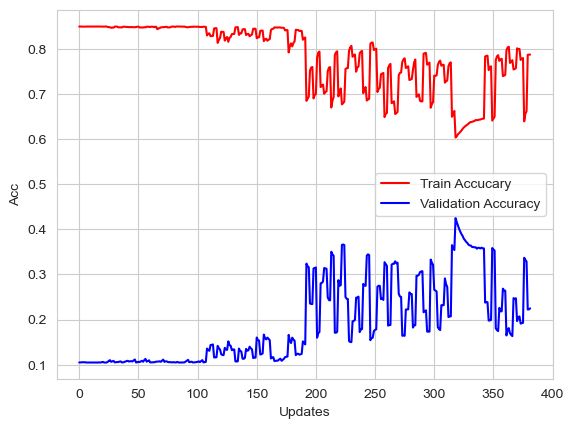

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
ivae = ivae.to(device)

# training..
training_epoch_data = []
test_epoch_data = []
test_acc, train_acc = [], []


for i in range(0,10):
    for j in range(i+1,10):
        for k in range(j+1,10):
            parentindice = [i,j,k]
            indices = torch.tensor(parentindice).to(device)
            print(indices)
            ivae_classifier = invariant_classifier.Classifier(indices).to(device)
            #Define loss function
            loss_fn = nn.BCELoss() 
            #The adam algorithm automatically use momentum
            optimizer = optim.Adam(ivae_classifier.parameters(), lr = 1e-4) 
            #TRAINING THE CLASSIFIER
            ivae.eval()
            epoch = 0
            num_epochs = 25 #hyper parametre
            #batch size hyper parameter can be changed in the dataloader in the beginning.


            while epoch < num_epochs:
                epoch+= 1
                training_batch_data = []
                test_batch_data = []
                ivae_classifier.train()
                
                # Go through each batch in the training dataset using the loader
                # Note that y is not necessarily known as it is here
                for sample in train_loader:
                    x = sample['image']
                    x = x.to(device)

                    y = sample['label'].to(torch.float32)
                    y = y.to(device)

                    e = sample['environment'].to(torch.float32)
                    e = e.to(device)
                    
                    # perform a forward pass through the model and compute the ELBO
                    qz = ivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                    z = qz.rsample()
                    z = torch.index_select(z, 1, indices)
                    z = z.to(device)

                    #Get classification prediction
                    output = ivae_classifier(z).view(-1)

                    loss = loss_fn(output, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # gather data for the current batch
                    training_batch_data.append(loss)
                        

                # gather data for the full epoch
                training_epoch_data.append(torch.tensor(training_batch_data).mean())

                #Evaluate training
                with torch.no_grad():
                    ivae_classifier.eval()
                    train_targs, train_preds = [], []
                    for sample in train_loader:
                        x = sample['image']
                        x = x.to(device)

                        y = sample['label']
                        y = y.to(device)

                        e = sample['environment']
                        e = e.to(device)
                        
                        # perform a forward pass through the model and compute the ELBO
                        qz = ivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                        z = qz.rsample()
                        z = torch.index_select(z, 1, indices)
                        z = z.to(device)

                        #Get classification prediction
                        output = ivae_classifier(z).view(-1)
                        prediction = torch.round(output)

                        train_targs += list(y.cpu().numpy())
                        train_preds += list(prediction.data.cpu().numpy())

                    #Evaluating validation
                    val_targs, val_preds = [], []
                    sample = next(inter(test_loader)) #Only validate on a subset of the test data.
                    x = sample['image']
                    x = x.to(device)

                    y = sample['label']
                    y = y.to(device)

                    e = sample['environment']
                    e = e.to(device)
                    
                    # perform a forward pass through the model and compute the ELBO
                    qz = ivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                    z = qz.rsample()
                    z = torch.index_select(z, 1, indices)
                    z = z.to(device)

                    #Get classification prediction
                    output = ivae_classifier(z).view(-1)
                    prediction = torch.round(output)


                    val_targs += list(y.cpu().numpy())
                    val_preds += list(prediction.data.cpu().numpy())

                train_acc_cur = invariant_classifier.accuracy(Tensor(train_targs),Tensor(train_preds))
                train_acc.append(train_acc_cur)

                test_acc_cur = invariant_classifier.accuracy(Tensor(val_targs),Tensor(val_preds))
                test_acc.append(test_acc_cur)
                print("Epoch %2i : , Train acc %f, Valid acc %f" % (
                            epoch, train_acc_cur, test_acc_cur))
                
                if epoch == 3:
                    if test_acc_cur < 0.4:
                        break

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

In [41]:
# # test_acc_2_parents_iVAE = test_acc
# # train_acc_2_parents_iVAE = train_acc

# with open("train_acc_3_parents_iVAE.txt", "w") as output:
#     output.write(str(train_acc_3_parents_iVAE))

In [43]:
# test_acc_3_parents_iVAE = test_acc
# train_acc_3_parents_iVAE = train_acc

In [56]:
with open("train_acc_3_parents_iVAE.txt", "w") as output:
    output.write(str(train_acc_3_parents_iVAE))

Testing the classifier in accordance with equation (12) in the article by *Lu et al*.

In [ ]:
#Load the full test dataset in order to learn the latent space given the decoder based on the full data.
test_data_full = DataLoader(cmnist_test_data, batch_size = 20000, batch_sampler = None)

sample = next(iter(test_data_full))

x_test = sample['image']
y_test = sample['label'].reshape(-1,1)
e_test = sample['environment'].reshape(-1,1)

x_test = x_test.to(device)
y_test = y_test.to(device)
e_test = e_test.to(device)

ivae = ivae.to(device)
output = ivae.forward(x_test, y_test, e_test)

z_test = output['z']

z_full = z_test.detach()
x_full = x_test.detach()
y_full = y_test.detach()
e_full = e_test.detach()

Zp = torch.randn(z_full.shape[0], nParents)
Zc = torch.randn(z_full.shape[0], nChildren)
Z = torch.randn(z_full.shape)

In [ ]:
num_epochs = 1200
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

Zp = Zp.to(device)
Zc = Zc.to(device)
Z = Z.to(device)

#ivae = ivae.to(device)
loss_BCE = nn.BCELoss()

Zp.requires_grad = True
Zc.requires_grad = True

optimizer = torch.optim.Adam(params=[Zp, Zc], lr=1e-2)

def get_reconstruction(Zp, Zc):
    Z[:,parents] = Zp
    Z[:,children] = Zc
    return(ivae.observation_model(Z))
 
for i in range(2*num_epochs):
    sample = next(iter(test_data_full))
    x = sample['image']
    x = x.to(device)

    px = get_reconstruction(Zp,Zc)
    loss = -px.log_prob(x)
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    print(Z[0,:])
    print("Step done")
    print(loss)

## Phase 1 iCaRL with NF-iVAE

In [ ]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 10 #Hyper parameter
nfivae = class_nfivae.NFiVAE(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(nfivae.parameters(), lr=1e-4) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

torch.manual_seed(1)
num_epochs = 1000 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f">> Using device: {device}")

# move the model to the device
nfivae = nfivae.to(device)
sample_counter = 0
# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    nfivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader: #tqdm
        sample_counter += 1
        
        x = sample['image']
        x = x.to(device)

        y = sample['label'].reshape(-1,1)
        y = y.to(device)

        e = sample['environment'].reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = nfivae.VariationalInference(x, y, e)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    px = outputs['px']
    samples = px.sample()

    xplot = x[0].to(torch.device("cpu"))
    samplesplot = samples[0].to(torch.device("cpu"))

    fig, axes = plt.subplots(2,2)
    show_CMNIST(xplot, label=int(y[0]), environment=int(e[0]), ax = axes[0,0])
    show_CMNIST(samplesplot, label=int(y[0]), environment=int(e[0]),  ax = axes[0,1])
    axes[1,0].plot(training_data['elbo'], label = "elbo")
    display(fig)
    clear_output(wait = True)

In [21]:
# torch.save(nfivae.state_dict(), '500epochs_NF_iVAE_var001_flipped_v2.pt')

Indsæt evt. med reconstruction eksempel fra test environment.

### iCaRL phase 2: PC-algorithm with NF-iVAE

In [ ]:
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

device = torch.device("cpu")
cmnist = ConcatDataset([cmnist_data1, cmnist_data2])
loader = DataLoader(cmnist, batch_size = 40000, batch_sampler = None)

sample = next(iter(loader))

x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)

x = x.to(device)
y = y.to(device)
e = e.to(device)

ivae = ivae.to(device)
output = ivae.forward(x, y, e)

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

z_df = pd.DataFrame(z.detach().cpu())
y_df = pd.DataFrame(y.detach().cpu())
e_df = pd.DataFrame(e.detach().cpu())

df = z_df; df['Y'] = y_df; df['E'] = e_df

df.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Y', 'E']
df.head()

In [ ]:
pc = PC(alpha=0.15)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.savefig('PC_NF-iVAE_alpha_005.png', transparent=True)
plt.show()

def find_parents(pc_array,y_pos,z_pos):
    ind = np.where(pc_array[z_pos,y_pos] == 1)
    ind_DAGpar = []
    ind_par = []
    for i in ind[0]:
        if pc_array[y_pos,i] == 0:
            ind_DAGpar.append(i)
        else:
            ind_par.append(i)
    return ind_DAGpar, ind_par

pc_array = pc._run_pc(df)


Define the parent latent variables such as to use these for the classification algorithm.

In [ ]:
#Automatic detection of parent indices based on PC algorithm
indices = torch.tensor(find_parents(pc_array, 10, range(0,10))[0]).to(device)
parents = indices
options = np.array([0,1,2,3,4,5,6,7,8,9])
children = np.delete(options, parents.cpu())
nParents = len(parents)
nChildren = 10 - nParents

### iCaRL phase 3: The invariant classifier for NF-iVAE

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nfivae = class_nfivae.NFiVAE(images[0].shape, 10)
nfivae.load_state_dict(torch.load('500epochs_NF_iVAE_var001_flipped_v2.pt', map_location=torch.device(device)))
nfivae = nfivae.to(device)


>> Using device: cuda:0
0.3518343098521569
0.70179810933403
0.23895079471252223
0.5956964693936807
0.188789367042843
0.10304480652089121
0.08694720734832162
0.8247448089519094
tensor([0, 1, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
Epoch  1 : , Train acc 0.503481, Valid acc 0.468750
Epoch  2 : , Train acc 0.506711, Valid acc 0.457031
Epoch  3 : , Train acc 0.538261, Valid acc 0.392578
Epoch  4 : , Train acc 0.604067, Valid acc 0.345703
0.8563861171759073
tensor([0, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
Epoch  1 : , Train acc 0.503481, Valid acc 0.468750
Epoch  2 : , Train acc 0.526392, Valid acc 0.441406
Epoch  3 : , Train acc 0.733173, Valid acc 0.285156
Epoch  4 : , Train acc 0.834635, Valid acc 0.173828
0.5578655787232835


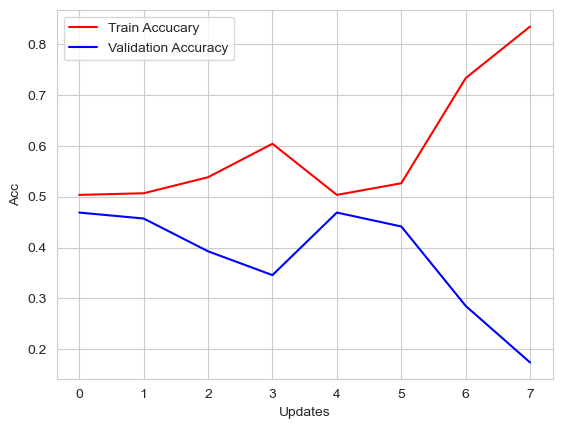

In [30]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
# nfivae = nfivae.to(device)

#Define loss function
loss_fn = nn.BCELoss() 

# training..
training_epoch_data = []
test_epoch_data = []
test_acc, train_acc = [], []

for i in range(0,10):
    for j in range(i+1,10):
        for k in range(j+1,10):
            for l in range(k+1,10):
                for h in range(l+1,10):
                    for m in range(h+1,10):
                        for n in range(m+1,10):
                            for o in range(n+1,10):
                                for r in range(o+1,10):
                                    torch.manual_seed(1+i)
                                    # draw a random number 
                                    random_number = np.random.rand()
                                    print(random_number)
                                    if random_number < 0.80:
                                        continue
                                    parentindice = [i,j,k,l,h,m,n,o,r]     
                                    indices = torch.tensor(parentindice).to(device)
                                    print(indices)
                                    nfivae_classifier = invariant_classifier.Classifier(indices).to(device)

                                    #The adam algorithm automatically use momentum
                                    optimizer = optim.Adam(nfivae_classifier.parameters(), lr = 1e-4) 

                                    #TRAINING THE CLASSIFIER
                                    nfivae.eval()
                                    epoch = 0
                                    num_epochs = 15 #hyper parametre
                                    #batch size hyper parameter can be changed in the dataloader in the beginning.
                                    while epoch < num_epochs:
                                        epoch+= 1
                                        training_batch_data = []
                                        test_batch_data = []
                                        nfivae_classifier.train()
                                        
                                        # Go through each batch in the training dataset using the loader
                                        # Note that y is not necessarily known as it is here
                                        for sample in train_loader:
                                            x = sample['image']
                                            x = x.to(device)

                                            y = sample['label'].to(torch.float32)
                                            y = y.to(device)        

                                            e = sample['environment'].to(torch.float32)
                                            e = e.to(device)
                                            
                                            # perform a forward pass through the model and compute the ELBO
                                            qz = nfivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                                            z = qz.rsample()
                                            z = torch.index_select(z, 1, indices)
                                            z = z.to(device)

                                            #Get classification prediction
                                            output = nfivae_classifier(z).view(-1)

                                            loss = loss_fn(output, y)

                                            optimizer.zero_grad()
                                            loss.backward()
                                            optimizer.step()
                                            
                                            # gather data for the current batch
                                            training_batch_data.append(loss)
                                                

                                        # gather data for the full epoch
                                        training_epoch_data.append(torch.tensor(training_batch_data).mean())

                                        #Evaluate training
                                        with torch.no_grad():
                                            nfivae_classifier.eval()
                                            train_targs, train_preds = [], []
                                            for sample in train_loader:
                                                x = sample['image']
                                                x = x.to(device)

                                                y = sample['label']
                                                y = y.to(device)

                                                e = sample['environment']
                                                e = e.to(device)
                                                
                                                # perform a forward pass through the model and compute the ELBO
                                                qz = nfivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                                                z = qz.rsample()
                                                z = torch.index_select(z, 1, indices)
                                                z = z.to(device)

                                                #Get classification prediction
                                                output = nfivae_classifier(z).view(-1)
                                                prediction = torch.round(output)

                                                train_targs += list(y.cpu().numpy())
                                                train_preds += list(prediction.data.cpu().numpy())

                                            #Evaluating validation
                                            val_targs, val_preds = [], []
                                            sample = next(iter(test_loader)) #only validate on a subset of the test data
                                            x = sample['image']
                                            x = x.to(device)

                                            y = sample['label']
                                            y = y.to(device)

                                            e = sample['environment']
                                            e = e.to(device)
                                            
                                            # perform a forward pass through the model and compute the ELBO
                                            qz = nfivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
                                            z = qz.rsample()
                                            z = torch.index_select(z, 1, indices)
                                            z = z.to(device)

                                            #Get classification prediction
                                            output = nfivae_classifier(z).view(-1)
                                            prediction = torch.round(output)


                                            val_targs += list(y.cpu().numpy())
                                            val_preds += list(prediction.data.cpu().numpy())

                                        train_acc_cur = invariant_classifier.accuracy(Tensor(train_targs),Tensor(train_preds))
                                        train_acc.append(train_acc_cur)

                                        test_acc_cur = invariant_classifier.accuracy(Tensor(val_targs),Tensor(val_preds))
                                        test_acc.append(test_acc_cur)
                                        print("Epoch %2i : , Train acc %f, Valid acc %f" % (
                                                    epoch, train_acc_cur, test_acc_cur))

                                        if epoch == 4:
                                            if test_acc_cur < 0.4:
                                                break

                                        if train_acc_cur > 0.75:
                                            break


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

test_acc_9_parents_NF_iVAE = test_acc
train_acc_9_parents_NF_iVAE = train_acc

with open("test_acc_9_parents_NF_iVAE.txt", "w") as output:
    output.write(str(test_acc_9_parents_NF_iVAE))

with open("train_acc_9_parents_NF_iVAE.txt", "w") as output:
    output.write(str(train_acc_9_parents_NF_iVAE))

In [81]:
np.min(test_acc_2_parents_NF_iVAE)

0.11242988782051282

In [93]:
print("Train")
print("min",np.min(train_acc_2_parents_iVAE), "2 parents")
print("min",np.min(train_acc_3_parents_iVAE), "3 parents")
print("max",np.max(train_acc_2_parents_iVAE), "2 parents")
print("max",np.max(train_acc_3_parents_iVAE), "3 parents")


print("Test")
print("min",np.min(test_acc_2_parents_iVAE), "2 parents")
print("min",np.min(test_acc_3_parents_iVAE), "3 parents")
print("max",np.max(test_acc_2_parents_iVAE), "2 parents")
print("max",np.max(test_acc_3_parents_iVAE), "3 parents")

Train
min 0.5723908253205128 2 parents
min 0.603515625 3 parents
max 0.8494090544871795 2 parents
max 0.8494591346153846 3 parents
Test
min 0.10496794871794872 2 parents
min 0.10496794871794872 3 parents
max 0.4605869391025641 2 parents
max 0.42497996794871795 3 parents


In [95]:
print("Train")
print("min",np.min(train_acc_2_parents_NF_iVAE), "2 parents")
print("min",np.min(train_acc_3_parents_NF_iVAE), "3 parents")
print("min",np.min(train_acc_4_parents_NF_iVAE), "4 parents")
print("min",np.min(train_acc_5_parents_NF_iVAE), "5 parents")
print("max",np.max(train_acc_2_parents_NF_iVAE), "2 parents")
print("max",np.max(train_acc_3_parents_NF_iVAE), "3 parents")
print("max",np.max(train_acc_4_parents_NF_iVAE), "4 parents")
print("max",np.max(train_acc_5_parents_NF_iVAE), "5 parents")



print("Test")
print("min",np.min(test_acc_2_parents_NF_iVAE), "2 parents")
print("min",np.min(test_acc_3_parents_NF_iVAE), "3 parents")
print("min",np.min(test_acc_4_parents_NF_iVAE), "4 parents")
print("min",np.min(test_acc_5_parents_NF_iVAE), "5 parents")
print("max",np.max(test_acc_2_parents_NF_iVAE), "2 parents")
print("max",np.max(test_acc_3_parents_NF_iVAE), "3 parents")
print("max",np.max(test_acc_4_parents_NF_iVAE), "4 parents")
print("max",np.max(test_acc_5_parents_NF_iVAE), "5 parents")

Train
min 0.4758613782051282 2 parents
min 0.48650340544871795 3 parents
min 0.5034805689102564 4 parents
min 0.5034805689102564 5 parents
max 0.8447766426282052 2 parents
max 0.8464042467948718 3 parents
max 0.8453776041666666 4 parents
max 0.8443008814102564 5 parents
Test
min 0.11242988782051282 2 parents
min 0.10837339743589744 3 parents
min 0.11388221153846154 4 parents
min 0.1219951923076923 5 parents
max 0.5050080128205128 2 parents
max 0.501953125 3 parents
max 0.5001502403846154 4 parents
max 0.5002504006410257 5 parents


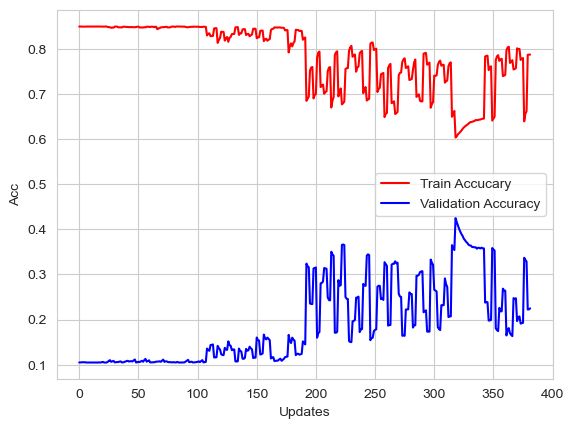

In [88]:
epoch = np.arange(len(test_acc_3_parents_iVAE))
plt.figure()
plt.plot(epoch, train_acc_3_parents_iVAE, 'r', epoch, test_acc_3_parents_iVAE, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

In [ ]:
#load the trained model
nfivae_classifier.load_state_dict(torch.load('50epochs_classifier_NF-iVAE100_flipped.pt', map_location=device))

Test the model predictions according to equation (12) in the article by *Lu et al 2022*.

In [ ]:
#classifier = classifier.to(device)
num_epochs = 50

test_data_full = DataLoader(cmnist_test_data, batch_size = 20000, batch_sampler = None)

sample = next(iter(test_data_full))

x_test = sample['image']
y_test = sample['label'].reshape(-1,1)
e_test = sample['environment'].reshape(-1,1)

x_test = x_test.to(device)
y_test = y_test.to(device)
e_test = e_test.to(device)

ivae = ivae.to(device)
output = ivae.forward(x_test, y_test, e_test)

z_test = output['z']

z_full = z_test.detach()
x_full = x_test.detach()
y_full = y_test.detach()
e_full = e_test.detach()

Zp = torch.randn(z_full.shape[0], nParents)
Zc = torch.randn(z_full.shape[0], nChildren)
Z = torch.randn(z_full.shape)


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

Zp = Zp.to(device)
Zc = Zc.to(device)
Z = Z.to(device)

#ivae = ivae.to(device)

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

Zp = Zp.to(device)
Zc = Zc.to(device)
Z = Z.to(device)

#ivae = ivae.to(device)
loss_BCE = nn.BCELoss()

Zp.requires_grad = True
Zc.requires_grad = True

optimizer = torch.optim.Adam(params=[Zp, Zc], lr=1e-2)

def get_reconstruction(Zp, Zc):
    Z[:,parents] = Zp
    Z[:,children] = Zc
    return(ivae.observation_model(Z))
 
for i in range(2*num_epochs):
    sample = next(iter(test_data_full))
    x = sample['image']
    x = x.to(device)

    px = get_reconstruction(Zp,Zc)
    loss = -px.log_prob(x)
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    print(Z[0,:])
    print("Step done")
    print(loss)